# Lectura y Transformación del conjunto de datos

    - Autor: Peio García Pinilla
    - Fecha: Julio de 2021
    
Este notebook hace referencia al Proyecto Fin de Máster: "Modelo Machine-Learning Del Cerebelo Para Adaptación De Movimientos Oculares". En él se lleva a cabo la lectura y adaptación del conjunto de datos experimental, al conjunto de datos que vamos a emplear para la generación de los modelos. También se incluye el código empleado para las primeras representaciones gráficas.

In [1]:
import os
import os.path
import sys
from os import listdir
import pandas as pd
import neo
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bisect import bisect_left
from matplotlib import patches
from matplotlib.animation import FuncAnimation
from scipy.ndimage import gaussian_filter1d

In [26]:
#Funciones Auxiliares
# Devuelve los arrays referentes a las posiciones horizontales del ojo y del target a lo largo del tiempo, 
# y los tiempos de cada medicion
def dev_h(data):
    aux = np.array(data.segments[0].analogsignals[1])
    t = data.segments[0].analogsignals[1].times.rescale('s').magnitude #Array con el tiempo
    if(aux.shape[1]<8):
        return ('x','x',0)
    else:
        eyex = aux[0:,0] #Array con las posiciones del ojo en x
        tarx = aux[0:,2] #Array con las posiciones del target en x
        return(np.array(eyex), np.array(tarx), t)

#Dibuja grafica de evolucion del trial entre dos instantes de tiempo
def eje_h(data, t1, t2):
    eyex, tarx, t = dev_h(data)
    plt.figure(figsize=(24, 10))
    p1, p2 = plt.plot(t, eyex, t, tarx)
    plt.legend(('HE', 'HT'),
            prop = {'size': 24}, loc='upper right')
    plt.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
    plt.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
    plt.xlim(t1,t2)
    plt.xlabel('Tiempo / s')
    plt.ylabel('Posición / deg')
    plt.title('Curva de movimiento en eje horizontal (un trial)')
    plt.show()

# Devuelve los arrays referentes a las posiciones horizontales del ojo y del target a lo largo del tiempo, 
# y los tiempos de cada medicion
def dev_v(data):
    aux = np.array(data.segments[0].analogsignals[1])
    t = data.segments[0].analogsignals[1].times.rescale('s').magnitude #Array con el tiempo
    if(aux.shape[1]<8):
        return ('x','x',0)
    else:
        eyey = aux[0:,1] #Array con las posiciones del ojo en y
        tary = aux[0:,3] #Array con las posiciones del target en y
        return(np.array(eyey), np.array(tary), t)

#Dibuja grafica de evolucion del trial entre dos instantes de tiempo
def eje_v(data, t1, t2):
    eyey, tary, t = dev_v(data)
    plt.figure(figsize=(24, 10))
    p1, p2 = plt.plot(t, eyey, t, tary)
    plt.legend(('VE', 'VT'),
            prop = {'size': 24}, loc='upper right')
    plt.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
    plt.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
    plt.xlim(t1,t2)
    plt.xlabel('Tiempo / s')
    plt.ylabel('Posición / deg')
    plt.title('Curva de movimiento en eje vertical (un trial)')
    plt.show()
    
#DEVUELVE ARRAYS CON LOS INSTANTES DE TIEMPO QUE EMPIEZAN Y TERMINAN LOS MOVIMIENTOS SACÁDICOS
def cuando(data):
    inicio = np.array(data.segments[0].events[0]) #Instante que comienzan las sacadas
    fin = np.array(data.segments[0].events[1]) #Instante que terminan las sacadas
    return (inicio, fin)

#Extrae el movimiento sacadico n del trial (devuelve posiciones inicio y fin del array, tiempos y duracion de la sac)
def extrae(data, n):
    t = data.segments[0].analogsignals[1].times.rescale('s').magnitude #Array con el tiempo
    inicio, final = cuando(data)
    i = inicio[n]
    f = final[n]
    
    #Instante de tiempo de posicion inicial
    pos_ini = bisect_left(t, i)
    if pos_ini == 0:
        pos_final_ini= pos_ini 
    if pos_ini == len(t):
        pos_final_ini= pos_ini  
    before = t[pos_ini - 1]
    after = t[pos_ini]
    if after - i < i - before:
        pos_final_ini = pos_ini
    else:
        pos_final_ini = pos_ini - 1

    #Instante de tiempo de posicion final
    pos_fin = bisect_left(t, f)
    if pos_fin == 0:
        pos_final_fin= pos_fin 
    if pos_fin == len(t):
        pos_final_fin= pos_fin  
    before = t[pos_fin - 1]
    after = t[pos_fin]
    if after - f < f - before:
        pos_final_fin = pos_fin
    else:
        pos_final_fin = pos_fin - 1
    return(pos_final_ini, pos_final_fin, i, f, f-i)

#Sacamos curva de velocidad (horizontal)
def derivar(pos, time):
    V = []
    current_pos = pos[0]
    current_ti = time[0]
    V.append(0)
    for i in range(1,len(pos)):
        p = pos[i]
        t = time[i]
        v = (p-current_pos)/(t-current_ti)
        V.append(v)
        current_pos = p
        current_ti = t
    return(V)

def dibuja_curva_vel_ac(t,v, flag=0):
    plt.figure(figsize=(24, 10))
    p1 = plt.plot(t, v)
    if(flag==0):
        plt.legend(('Vel. (deg/s)'),
                prop = {'size': 24}, loc='upper right')
        plt.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
        plt.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Velocidad (deg/s)')
        plt.title('Curva de velocidad en eje horizontal (una sacada)')
    else:
        plt.legend(('Acel. (deg/s^2)'),
                prop = {'size': 24}, loc='upper right')
        plt.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
        plt.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Aceleración (deg/s^2)')
        plt.title('Curva de aceleración en eje horizontal (una sacada)')        
    plt.show()

def dibuja_sacada(ex,ey, vx, vy):
    figure, axes = plt.subplots(figsize=(10,10))

    #Circunferencia del contorno del ojo
    draw_circle = plt.Circle((0, 0), 27,fill=False)
    Hinicio=ex[0]
    Vinicio=ey[0]
    Hfinal=ex[len(ex)-1]
    Vfinal=ey[len(ey)-1]
    vxmax = max(vx)
    vymax = max(vy)
    #Circulos con posiciones inicio, final y objetivo
    draw_circle1 = plt.Circle((Hinicio, Vinicio), 2,fill=True, color='black') #Posición inicial de la retina
    draw_circle3 = plt.Circle((Hfinal, Vfinal), 2,fill=False, color='green',alpha=0.7) #Posición final del ojo tras movimiento
    axes.set_aspect(1)
    axes.add_artist(draw_circle)
    axes.add_artist(draw_circle1)
    axes.add_artist(draw_circle3)
    for j in range(1, len(ex)-2):
        if(vx[j]==vxmax):
            draw_circlex= plt.Circle((ex[j], ey[j]), 0.5,fill=True, color='red',alpha=0.7)
        elif(vy[j]==vymax):
            draw_circlex= plt.Circle((ex[j], ey[j]), 0.5,fill=True, color='purple',alpha=0.7)
        else:
            draw_circlex= plt.Circle((ex[j], ey[j]), 0.05,fill=False, color='blue',alpha=0.7) #
        axes.add_artist(draw_circlex)
        
    #Dibujamos grafica
    plt.title('Movimiento sacádico')
    plt.xlabel('Posición horizontal (deg)')
    plt.ylabel('Posición vertical (deg)')
    axes.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
    axes.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
    plt.xlim(-30,30)
    plt.ylim(-30,30)
    plt.xticks(range(-30,30,5))
    plt.yticks(range(-30,30,5))
    colors = ["black", "green", "red"]
    texts = ["Posición inicial", "Posición final", "Velocidad máxima"]
    patches = [ axes.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
                label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
    axes.legend(handles=patches, ncol=1 )
    plt.show()

    
#Grafico de evolucion del entrenamiento
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
               label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
               label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
               label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
               label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

def dibuja_sacada(ex,ey, vx, vy):
    figure, axes = plt.subplots(figsize=(10,10))

    #Circunferencia del contorno del ojo
    draw_circle = plt.Circle((0, 0), 27,fill=False)
    Hinicio=ex[0]
    Vinicio=ey[0]
    Hfinal=ex[len(ex)-1]
    Vfinal=ey[len(ey)-1]
    vxmax = max(vx)
    vymax = max(vy)
    #Circulos con posiciones inicio, final y objetivo
    draw_circle1 = plt.Circle((Hinicio, Vinicio), 2,fill=True, color='black') #Posición inicial de la retina
    draw_circle3 = plt.Circle((Hfinal, Vfinal), 2,fill=False, color='green',alpha=0.7) #Posición final del ojo tras movimiento
    axes.set_aspect(1)
    axes.add_artist(draw_circle)
    axes.add_artist(draw_circle1)
    axes.add_artist(draw_circle3)
    for j in range(1, len(ex)-2):
        if(vx[j]==vxmax):
            draw_circlex= plt.Circle((ex[j], ey[j]), 0.5,fill=True, color='red',alpha=0.7)
        elif(vy[j]==vymax):
            draw_circlex= plt.Circle((ex[j], ey[j]), 0.5,fill=True, color='purple',alpha=0.7)
        else:
            draw_circlex= plt.Circle((ex[j], ey[j]), 0.05,fill=False, color='blue',alpha=0.7) #
        axes.add_artist(draw_circlex)
        
    #Dibujamos grafica
    plt.title('Movimiento sacádico')
    plt.xlabel('Posición horizontal (deg)')
    plt.ylabel('Posición vertical (deg)')
    axes.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
    axes.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
    plt.xlim(-30,30)
    plt.ylim(-30,30)
    plt.xticks(range(-30,30,5))
    plt.yticks(range(-30,30,5))
    colors = ["black", "green", "red"]
    texts = ["Posición inicial", "Posición final", "Velocidad máxima"]
    patches = [ axes.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
                label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
    axes.legend(handles=patches, ncol=1 )
    plt.show()

In [3]:
#######################################################################
# Leemos un fichero de ejemplo para graficar primeras visualizaciones #
#######################################################################
ruta_ds = '2010_Adapt/'
reader = neo.io.Spike2IO(filename=ruta_ds + 'B091908_1_1509_Adapt.smr')
data = reader.read()[0]

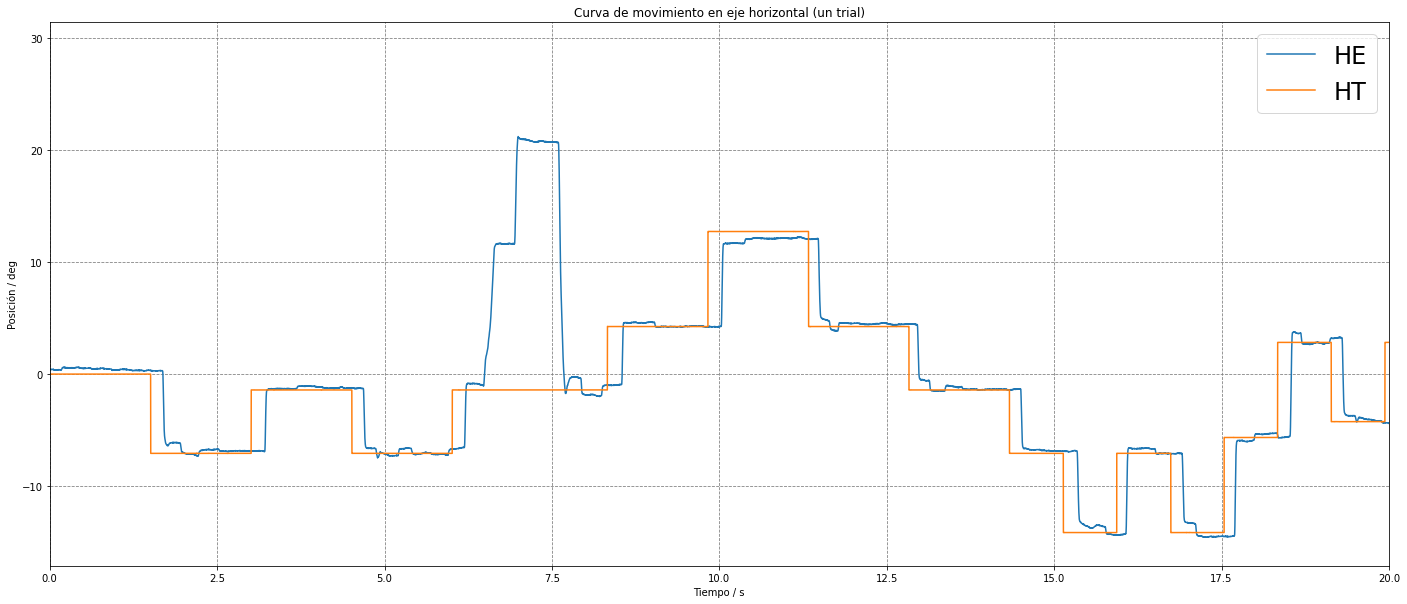

In [4]:
eje_h(data, 0, 20)

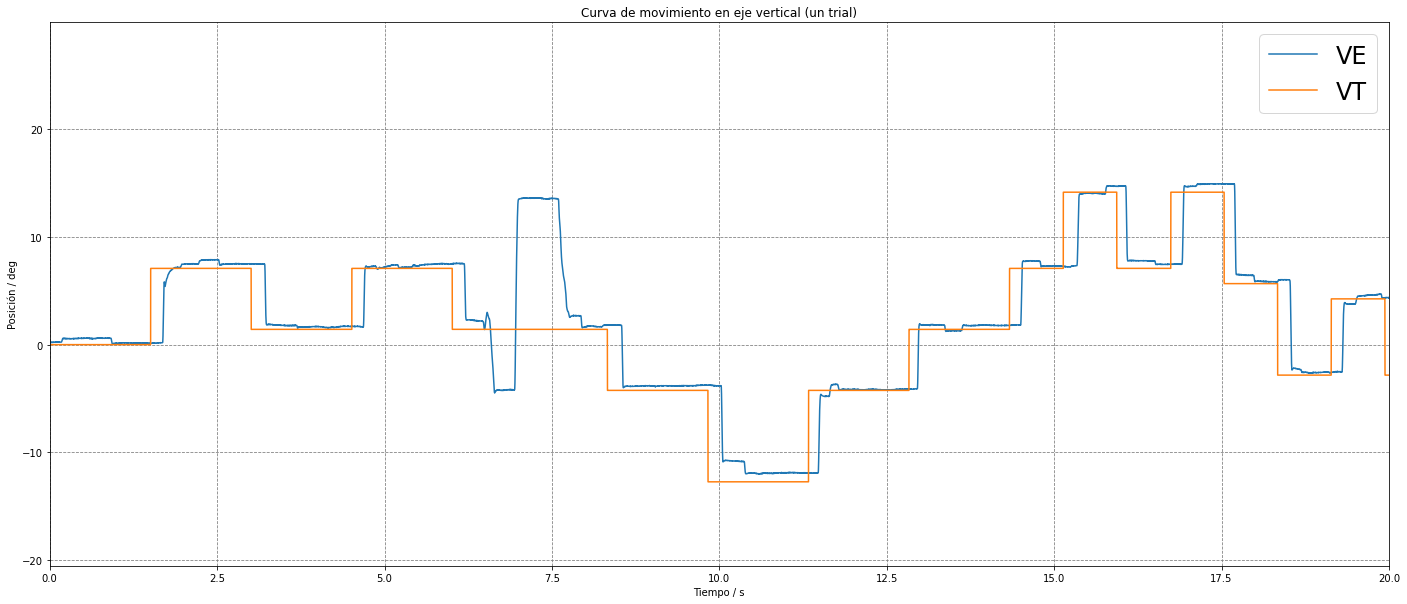

In [5]:
eje_v(data, 0, 20)

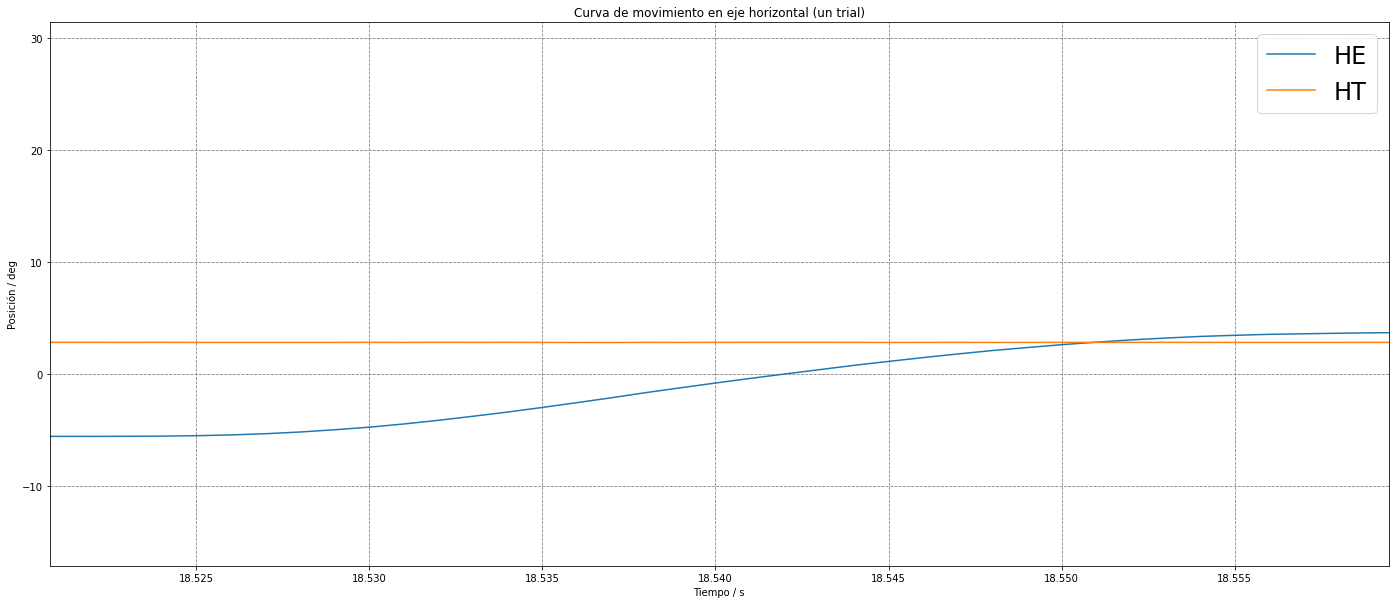

In [6]:
#Un solo movimiento sacadico empleando las funciones anteriores
pos_i, pos_f, i, f, dur = extrae(data, 13)
eje_h(data, i, f)

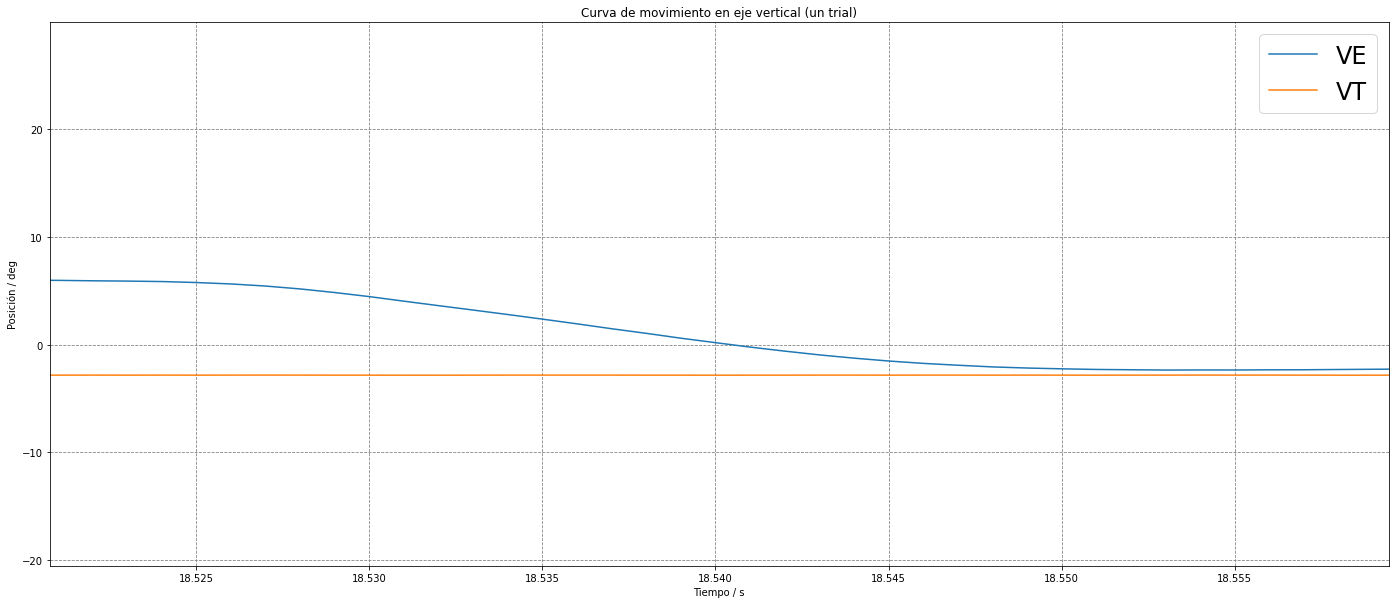

In [7]:
eje_v(data, i, f)

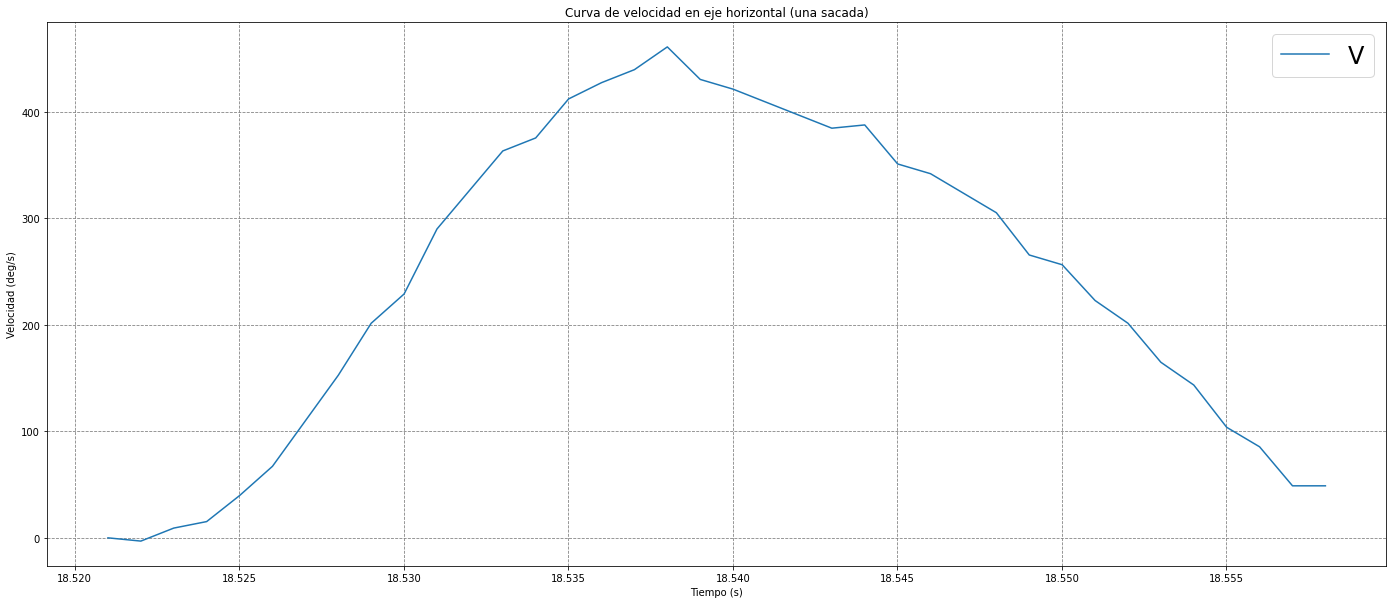

In [8]:
##### VELOCIDAD EJE HORIZONTAL#####
eyex, tarx, t = dev_h(data) #Cogemos datos del eje horizontal
s_eyex = eyex[pos_i:pos_f] #Posiciones del ojo durante la sacada
s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
vx = derivar(s_eyex, s_t) #Calculamos curva de velocidad
dibuja_curva_vel_ac(s_t, vx, 0)

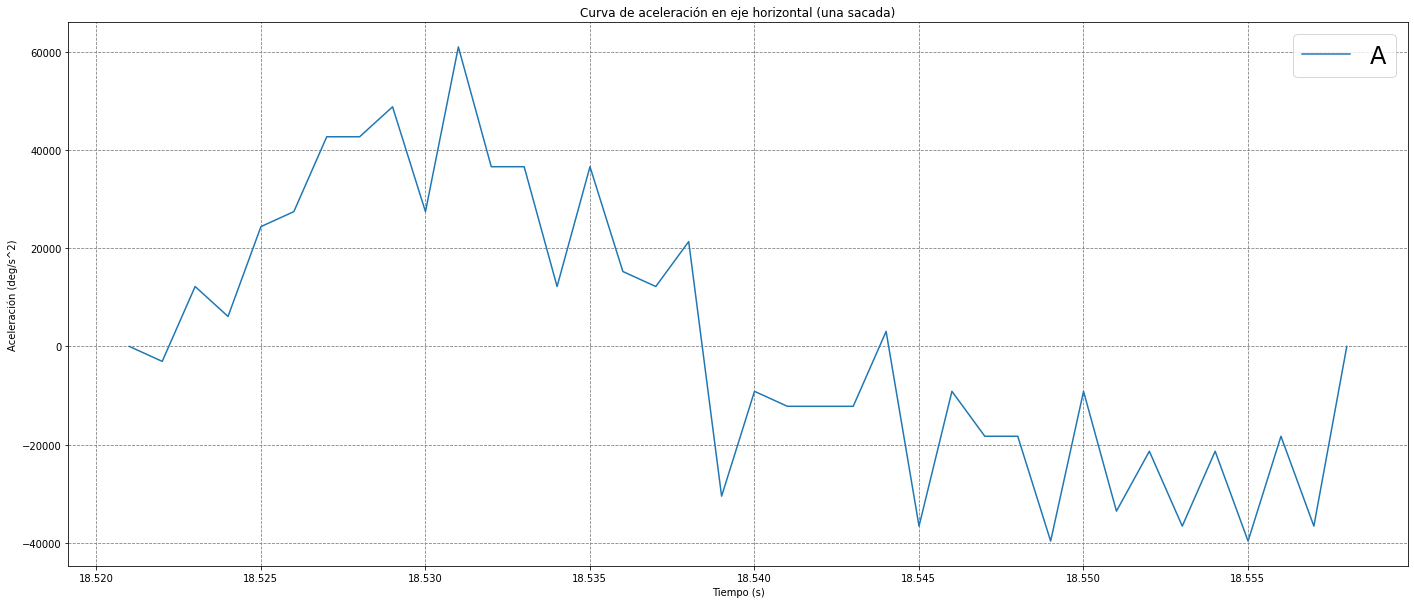

In [9]:
###### ACELERACION EJE HORIZONTAL#####
ax = derivar(vx, s_t) #Calculamos curva de aceleracion (2nda derivada)
dibuja_curva_vel_ac(s_t, ax, 1)

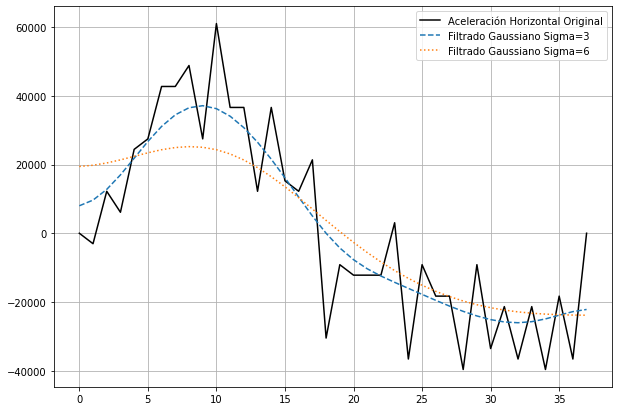

In [10]:
#Como sale algo ruidoso, aplicar filtro de suavizado lineal
ax3 = gaussian_filter1d(ax, 3)
ax6 = gaussian_filter1d(ax, 6)
plt.figure(figsize=(10,7))
plt.plot(ax, 'k', label='Aceleración Horizontal Original')
plt.plot(ax3, '--', label='Filtrado Gaussiano Sigma=3')
plt.plot(ax6, ':', label='Filtrado Gaussiano Sigma=6')
plt.legend()
plt.grid()
plt.show()

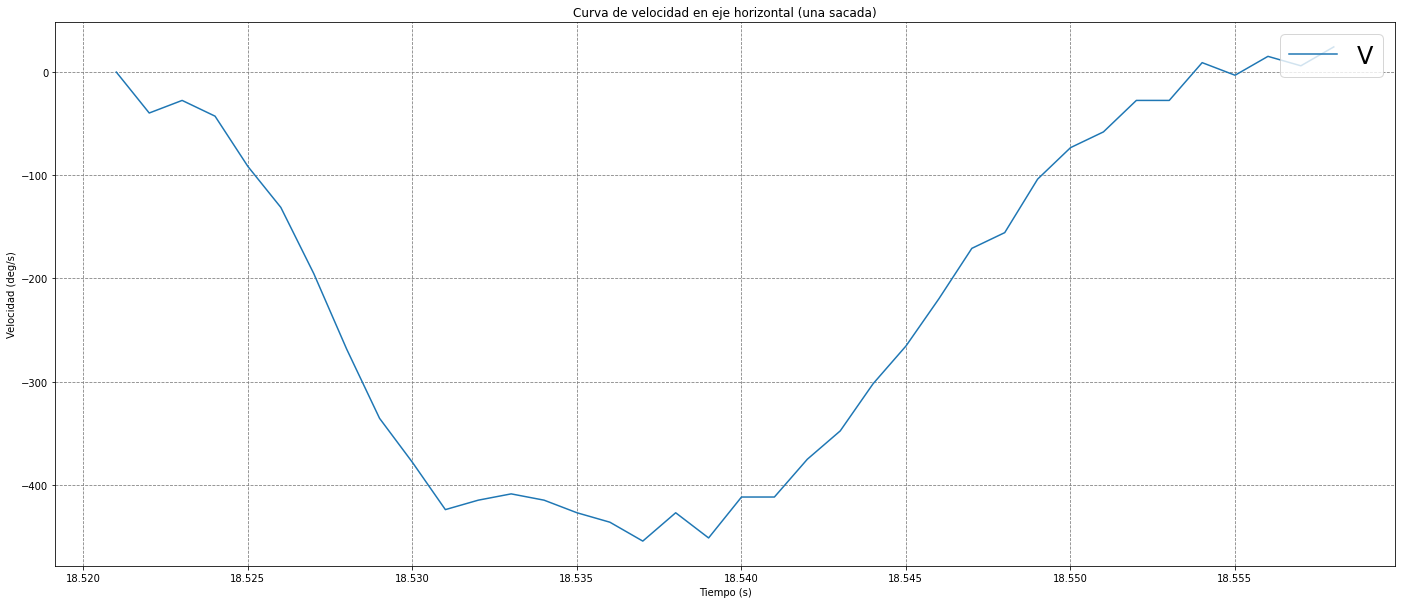

In [12]:
#Mismo proceso para el eje vertical
##### VELOCIDAD EJE VERTICAL#####
eyey, tary, t = dev_v(data) #Cogemos datos del eje veryical
s_eyey = eyey[pos_i:pos_f] #Posiciones del ojo durante la sacada
s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
vy = derivar(s_eyey, s_t) #Calculamos curva de velocidad
dibuja_curva_vel_ac(s_t, vy, 0)

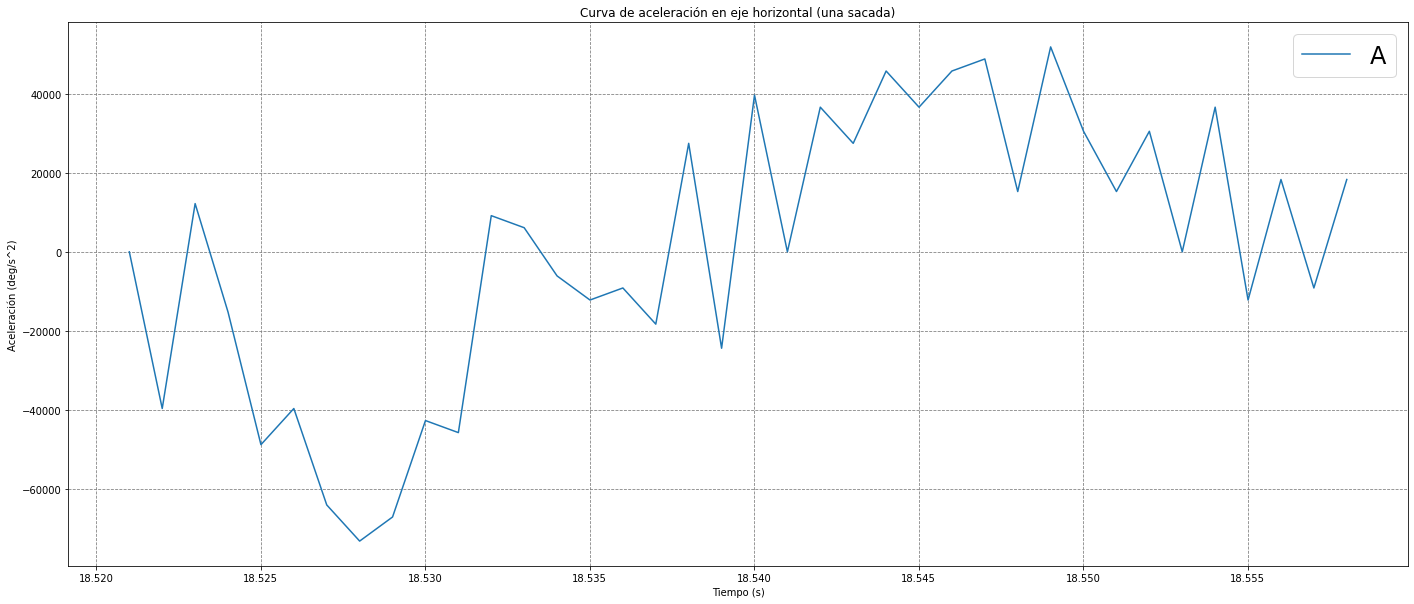

In [13]:
###### ACELERACION EJE VERTICAL#####
ax = derivar(vy, s_t) #Calculamos curva de aceleracion (2nda derivada)
dibuja_curva_vel_ac(s_t, ax, 1)

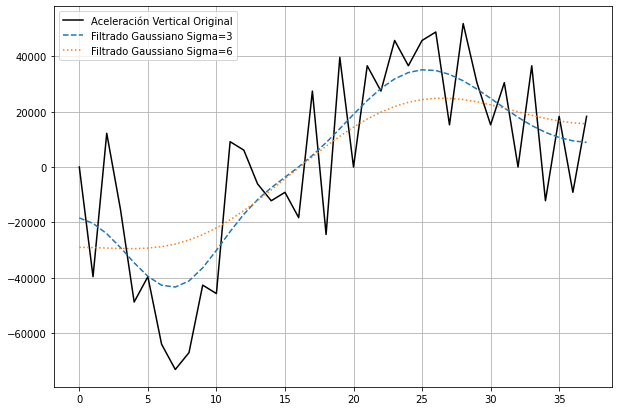

In [14]:
#Filtro de suavizado lineal
#Como sale algo ruidoso, aplicar filtro de suavizado lineal
ay3 = gaussian_filter1d(ax, 3)
ay6 = gaussian_filter1d(ax, 6)
plt.figure(figsize=(10,7))
plt.plot(ax, 'k', label='Aceleración Vertical Original')
plt.plot(ay3, '--', label='Filtrado Gaussiano Sigma=3')
plt.plot(ay6, ':', label='Filtrado Gaussiano Sigma=6')
plt.legend()
plt.grid()
plt.show()

Text(0.5, 1.0, 'Curvas de velocidad segun posición final del ojo (EJE HORIZONTAL)')

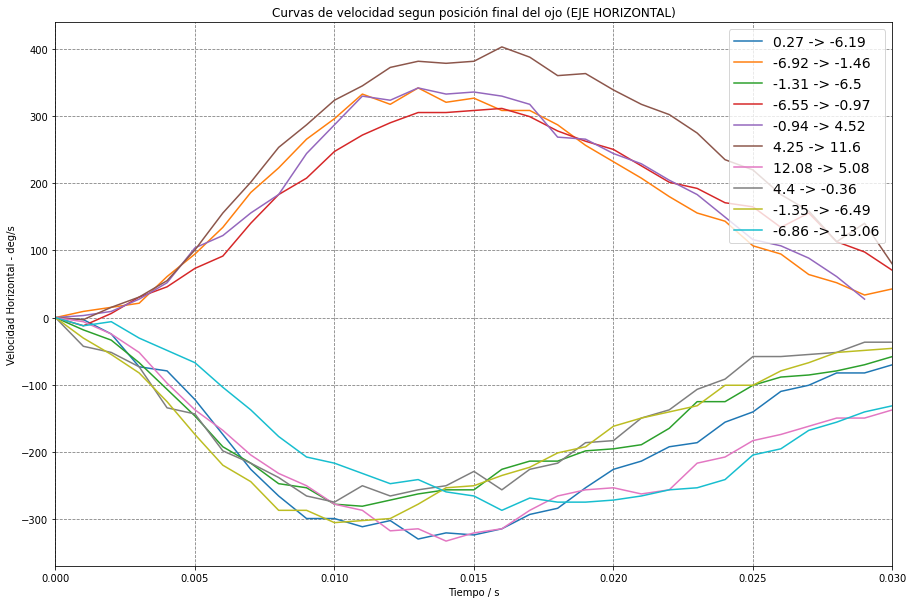

In [15]:
#DISTINTAS CURVAS DE VELOCIDAD SEGUN LA POSICION FINAL DEL OJO HORIZONTAL
#Cuanto mas larga sea la 
plt.figure(figsize=(15,10))
finales = []
for i in range(0,10):
    pos_i, pos_f, i, f, dur = extrae(data, i)
    eyex, tarx, t = dev_h(data) #Cogemos datos del eje horizontal
    s_eyex = eyex[pos_i:pos_f] #Posiciones del ojo durante la sacada
    s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
    ei = eyex[pos_i]    #Pos inicial del ojo
    ef = eyex[pos_f]    #Pos final del ojo
    ct = s_t-min(s_t)   #Current time
    finales.append(str(round(ei,2)) + ' -> ' + str(round(ef,2)))
    vx = derivar(s_eyex, s_t) #Calculamos curva de velocidad
    plt.plot(ct,vx)
plt.legend((finales[0],finales[1],finales[2],finales[3],finales[4],finales[5],finales[6],
           finales[7],finales[8],finales[9]),
            prop = {'size': 14}, loc='upper right')
plt.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
plt.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
plt.xlabel('Tiempo / s')
plt.xlim(0,0.03)
plt.ylabel('Velocidad Horizontal - deg/s')
plt.title('Curvas de velocidad segun posición final del ojo (EJE HORIZONTAL)')

Text(0.5, 1.0, 'Curvas de velocidad segun posición final del ojo (EJE VERTICAL)')

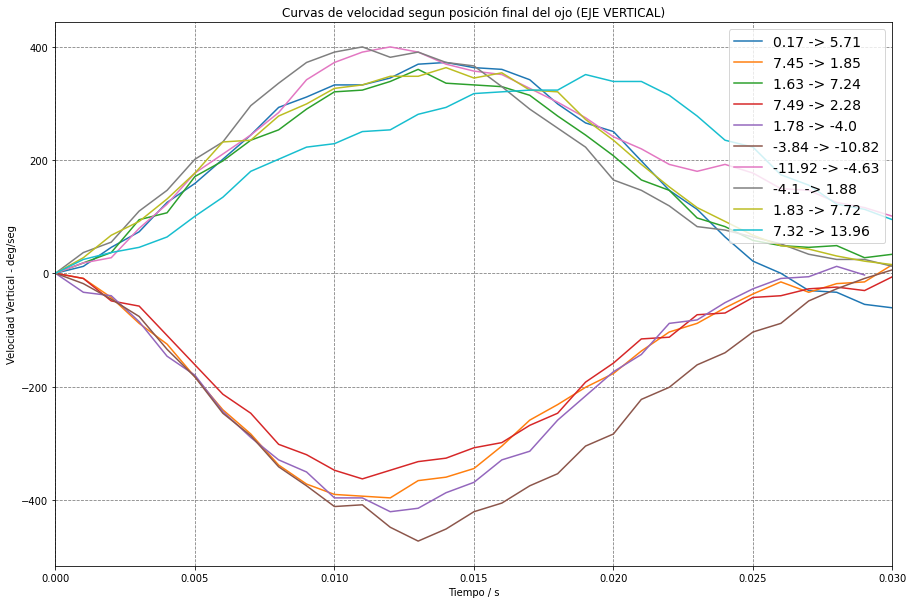

In [16]:
#DISTINTAS CURVAS DE VELOCIDAD SEGUN LA POSICION FINAL DEL OJO VERTICAL
plt.figure(figsize=(15,10))
finales = []
for i in range(0,10):
    pos_i, pos_f, i, f, dur = extrae(data, i)
    eyex, tarx, t = dev_v(data) #Cogemos datos del eje horizontal
    s_eyey = eyey[pos_i:pos_f] #Posiciones del ojo durante la sacada
    s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
    ei = eyey[pos_i]    #Pos inicial del ojo
    ef = eyey[pos_f]    #Pos final del ojo
    ct = s_t-min(s_t)   #Current time
    finales.append(str(round(ei,2)) + ' -> ' + str(round(ef,2)))
    vy = derivar(s_eyey, s_t) #Calculamos curva de velocidad
    plt.plot(ct, vy)
plt.legend((finales[0],finales[1],finales[2],finales[3],finales[4],finales[5],finales[6],
           finales[7],finales[8],finales[9]),
            prop = {'size': 14}, loc='upper right')
plt.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
plt.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
plt.xlabel('Tiempo / s')
plt.xlim(0,0.03)
plt.ylabel('Velocidad Vertical - deg/seg')
plt.title('Curvas de velocidad segun posición final del ojo (EJE VERTICAL)')

Text(0.5, 1.0, 'Curvas de aceleración segun posición final del ojo (EJE HORIZONTAL)')

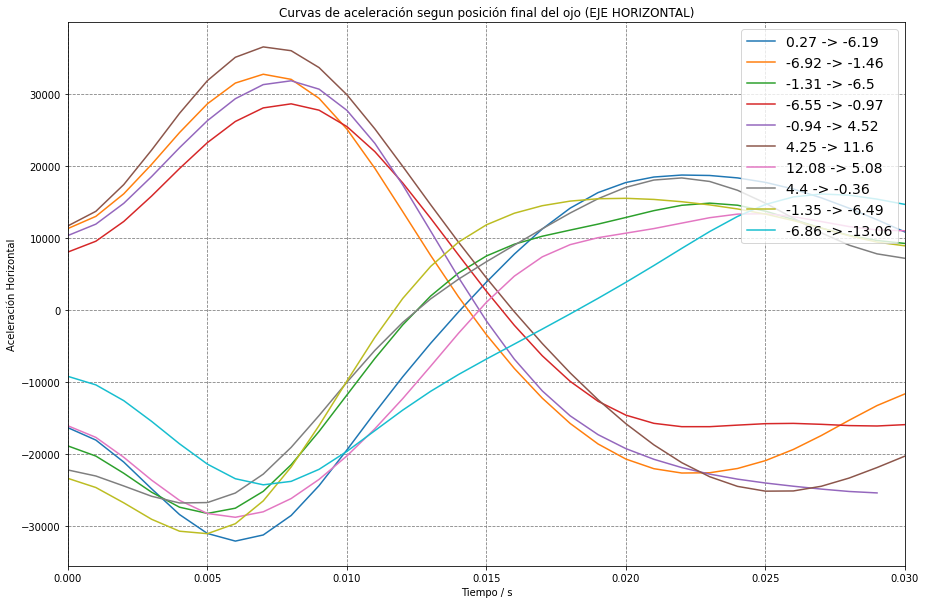

In [17]:
#DISTINTAS CURVAS DE ACELERACION SEGUN LA POSICION FINAL DEL OJO HORIZONTAL (suavizado)
#Se aprecia en donde hfinal es positiva -> ac primero negativa luego pos
plt.figure(figsize=(15,10))
finales = []
for i in range(0,10):
    pos_i, pos_f, i, f, dur = extrae(data, i)
    eyex, tarx, t = dev_h(data) #Cogemos datos del eje horizontal
    s_eyex = eyex[pos_i:pos_f] #Posiciones del ojo durante la sacada
    s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
    ei = eyex[pos_i]    #Pos inicial del ojo
    ef = eyex[pos_f]    #Pos final del ojo
    ct = s_t-min(s_t)   #Current time
    finales.append(str(round(ei,2)) + ' -> ' + str(round(ef,2)))
    vx = derivar(s_eyex, s_t) #Calculamos curva de velocidad
    ax = derivar(vx, s_t) #Calculamos curva de velocidad
    ax = gaussian_filter1d(ax, 3)
    plt.plot(ct,ax)
plt.legend((finales[0],finales[1],finales[2],finales[3],finales[4],finales[5],finales[6],
           finales[7],finales[8],finales[9]),
            prop = {'size': 14}, loc='upper right')
plt.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
plt.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
plt.xlabel('Tiempo / s')
plt.xlim(0,0.03)
plt.ylabel('Aceleración Horizontal')
plt.title('Curvas de aceleración segun posición final del ojo (EJE HORIZONTAL)')

Text(0.5, 1.0, 'Curvas de aceleración segun posición final del ojo (EJE VERTICAL)')

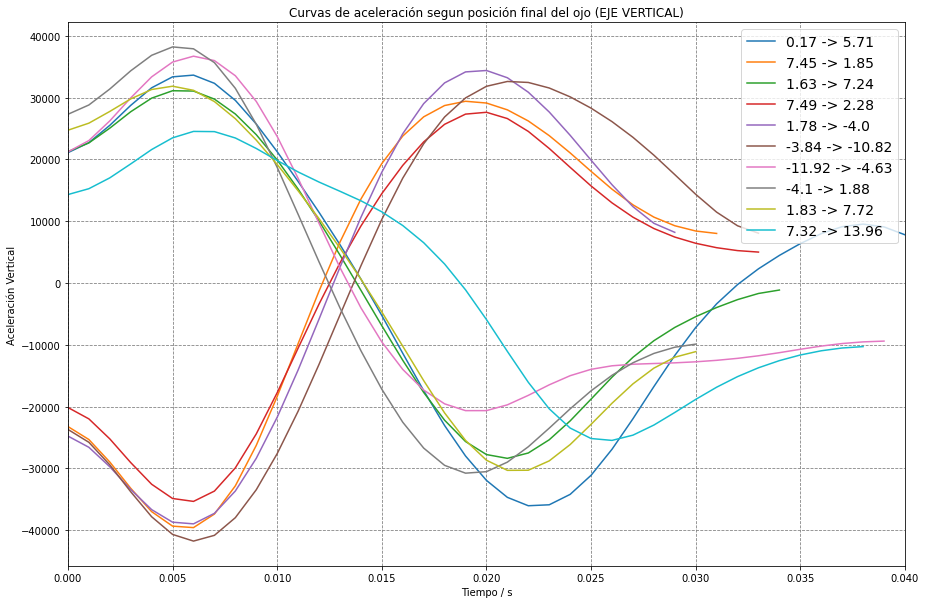

In [18]:
#DISTINTAS CURVAS DE ACELERACION SEGUN LA POSICION FINAL DEL OJO VERTICAL
plt.figure(figsize=(15,10))
finales = []
for i in range(0,10):
    pos_i, pos_f, i, f, dur = extrae(data, i)
    eyex, tarx, t = dev_v(data) #Cogemos datos del eje horizontal
    s_eyey = eyey[pos_i:pos_f] #Posiciones del ojo durante la sacada
    s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
    ei = eyey[pos_i]    #Pos inicial del ojo
    ef = eyey[pos_f]    #Pos final del ojo
    ct = s_t-min(s_t)   #Current time
    finales.append(str(round(ei,2)) + ' -> ' + str(round(ef,2)))
    vy = derivar(s_eyey, s_t) #Calculamos curva de velocidad
    ay = derivar(vy, s_t) #Calculamos curva de aceleracion
    ay = gaussian_filter1d(ay, 3)
    plt.plot(ct, ay)
plt.legend((finales[0],finales[1],finales[2],finales[3],finales[4],finales[5],finales[6],
           finales[7],finales[8],finales[9]),
            prop = {'size': 14}, loc='upper right')
plt.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
plt.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
plt.xlabel('Tiempo / s')
plt.xlim(0,0.04)
plt.ylabel('Aceleración Vertical')
plt.title('Curvas de aceleración segun posición final del ojo (EJE VERTICAL)')

In [19]:
#CALCULAMOS MOVIMIENTO DE MISMA LONGITUD Y DIRECCION PARA POSTERIORMENTE CALCULAR LAS CURVAS
pos_i, pos_f, i, f, dur = extrae(data, 10)
eyex, tarx, t = dev_h(data) #Cogemos datos del eje horizontal
eyey, tary, t = dev_v(data) #Cogemos datos del eje vertical
laux = []
s_eyex = eyex[pos_i:pos_f] #Posiciones del ojo durante la sacada
s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
ei = eyex[pos_i]    #Pos inicial del ojo
ef = eyex[pos_f]    #Pos final del ojo

s_eyey = eyey[pos_i:pos_f] #Posiciones del ojo v durante la sacada
ei2 = eyey[pos_i]    #Pos inicial del ojov
ef2 = eyey[pos_f]    #Pos final del ojo v
ct = s_t-min(s_t)   #Current time

print(ei)
print(ef)
print(ei2)
print(ef2)

longitud = np.sqrt((ef-ei)**2 + (ef2-ei2)**2)
sel=[10]
cont=1
for z in range(11,1000):
    if(cont>9):
        break
    pos_i, pos_f, i, f, dur = extrae(data, z)
    eyex, tarx, t = dev_h(data) #Cogemos datos del eje horizontal
    eyey, tary, t = dev_v(data) #Cogemos datos del eje vertical
    s_eyex = eyex[pos_i:pos_f] #Posiciones del ojo durante la sacada
    s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
    ei = eyex[pos_i]    #Pos inicial del ojo
    ef = eyex[pos_f]    #Pos final del ojo
    s_eyey = eyey[pos_i:pos_f] #Posiciones del ojo v durante la sacada
    ei2 = eyey[pos_i]    #Pos inicial del ojov
    ef2 = eyey[pos_f]    #Pos final del ojo v
    ct = s_t-min(s_t)   #Current time
    
    l = np.sqrt((ef-ei)**2 + (ef2-ei2)**2)
    laux.append(l)
    if(abs(l-longitud)<0.05 and (ef-ei)>0 and (ef2-ei2)<0): #Misma direccion y misma longitud
        sel.append(z)
        cont += 1

-14.260864
-6.6864014
14.700317
7.763672


Text(0.5, 1.0, 'Curvas de velocidad segun posición final del ojo (EJE HORIZONTAL)')

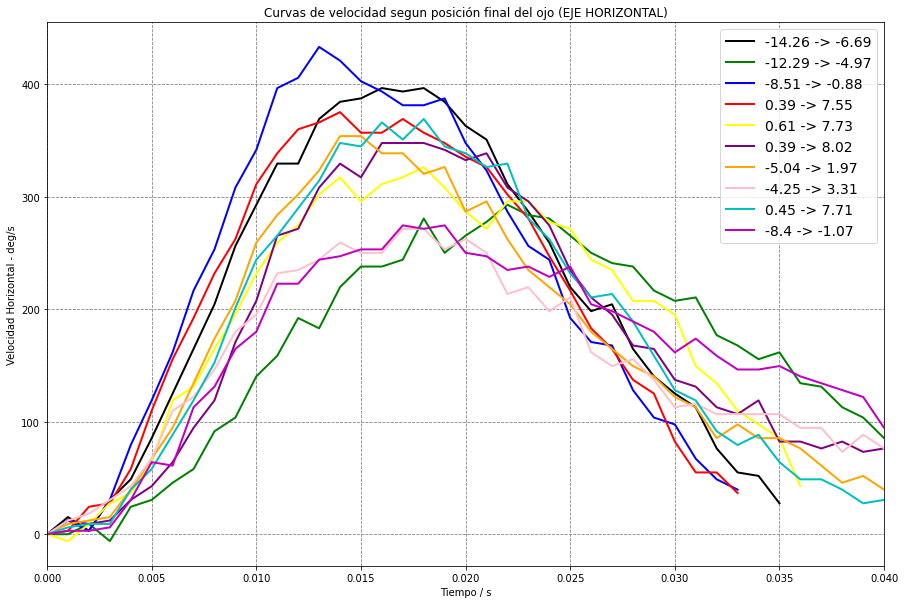

In [20]:
#COMPARACION DE CURVAS DE MOVIMIENTO CON MISMA LONGITUD
#DISTINTAS CURVAS DE VELOCIDAD SEGUN LA POSICION FINAL DEL OJO HORIZONTAL
#Cuanto mas larga sea la 
plt.figure(figsize=(15,10))
finales = []
colors = ['black', 'green', 'blue', 'red', 'yellow', 'purple', 'orange', 'pink', 'c', 'm']
co=0
for z in sel:
    pos_i, pos_f, i, f, dur = extrae(data, z)
    eyex, tarx, t = dev_h(data) #Cogemos datos del eje horizontal
    s_eyex = eyex[pos_i:pos_f] #Posiciones del ojo durante la sacada
    s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
    ei = eyex[pos_i]    #Pos inicial del ojo
    ef = eyex[pos_f]    #Pos final del ojo
    ct = s_t-min(s_t)   #Current time
    finales.append(str(round(ei,2)) + ' -> ' + str(round(ef,2)))
    vx = derivar(s_eyex, s_t) #Calculamos curva de velocidad
    plt.plot(ct,vx, label=finales[co], linewidth=2, color=colors[co])
    #plt.plot(ct,vx, label=finales[co], linewidth=2, linestyle='--', color=colors[co])
    co+=1
plt.legend((finales[0],finales[1],finales[2],finales[3],finales[4],finales[5],finales[6],
            finales[7],finales[8],finales[9]),
            prop = {'size': 14}, loc='upper right')
plt.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
plt.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
plt.xlabel('Tiempo / s')
plt.xlim(0,0.04)
plt.ylabel('Velocidad Horizontal - deg/s')
plt.title('Curvas de velocidad segun posición final del ojo (EJE HORIZONTAL)')

Text(0.5, 1.0, 'Curvas de velocidad segun posición final del ojo (EJE VERTICAL)')

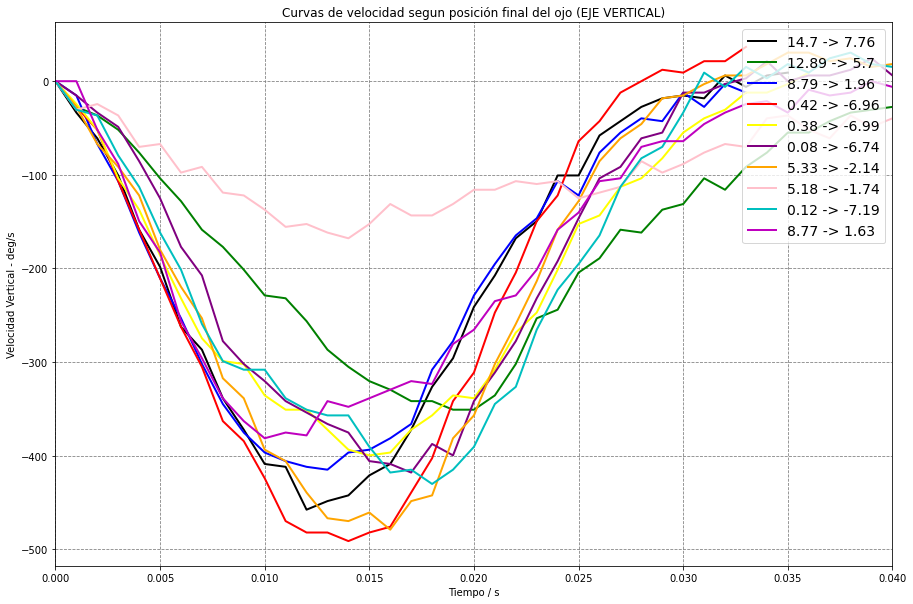

In [21]:
#COMPARACION DE CURVAS DE MOVIMIENTO CON MISMA LONGITUD Y DIRECCION
#DISTINTAS CURVAS DE VELOCIDAD SEGUN LA POSICION FINAL DEL OJO VERTICAL
#Cuanto mas larga sea la 
plt.figure(figsize=(15,10))
finales = []
colors = ['black', 'green', 'blue', 'red', 'yellow', 'purple', 'orange', 'pink', 'c', 'm']
co=0
for z in sel:
    pos_i, pos_f, i, f, dur = extrae(data, z)
    eyex, tarx, t = dev_v(data) #Cogemos datos del eje horizontal
    s_eyex = eyex[pos_i:pos_f] #Posiciones del ojo durante la sacada
    s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
    ei = eyex[pos_i]    #Pos inicial del ojo
    ef = eyex[pos_f]    #Pos final del ojo
    ct = s_t-min(s_t)   #Current time
    finales.append(str(round(ei,2)) + ' -> ' + str(round(ef,2)))
    vx = derivar(s_eyex, s_t) #Calculamos curva de velocidad
    plt.plot(ct,vx, label=finales[co], linewidth=2, color=colors[co])
    co+=1
plt.legend((finales[0],finales[1],finales[2],finales[3],finales[4],finales[5],finales[6],
            finales[7],finales[8],finales[9]),
            prop = {'size': 14}, loc='upper right')
plt.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
plt.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
plt.xlabel('Tiempo / s')
plt.xlim(0,0.04)
plt.ylabel('Velocidad Vertical - deg/s')
plt.title('Curvas de velocidad segun posición final del ojo (EJE VERTICAL)')

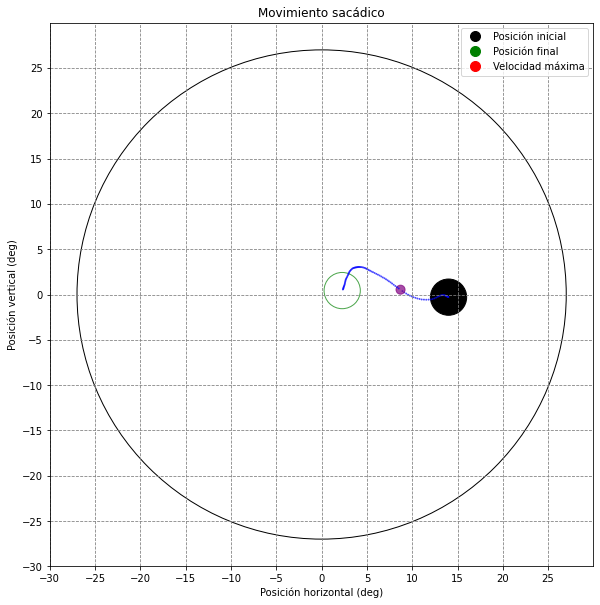

Duración del movimiento sacádico (s):  0.048


In [27]:
#Punto negro -> Punto inicial del ojo
#Punto azul -> Punto final del ojo
dibuja_sacada(s_eyex, s_eyey, vx, vy)
print("Duración del movimiento sacádico (s): ", round(ct[len(ct)-1],5))

In [ ]:
##########################################################################
# Fragmento de código para crear el df de la visualización de processing #
##########################################################################
df=pd.DataFrame(columns=['x','y','Hinicio', 'Hfinal', 'Vinicio', 'Vfinal', 'HT', 'VT', 'Vx', 'Vy', 't'])
aux=0
tiempo=0
for k in range(0,50):
    pos_i, pos_f, i, f, dur = extrae(data, k)
    s_eyex = eyex[pos_i:pos_f]
    s_eyey = eyey[pos_i:pos_f] #Posiciones del ojo durante la sacada
    s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
    vx = derivar(s_eyex, s_t) #Calculamos curva de velocidad
    vy = derivar(s_eyey, s_t)
    eix=eyex[pos_i]
    eiy=eyey[pos_i]
    efx=eyex[pos_f]
    efy=eyey[pos_f]
    ct = s_t-min(s_t)
    tfinal = ct + tiempo
    for i in range(0,len(vx)):
        d={'x':eyex[pos_i+i], 'y':eyey[pos_i+i],'Hinicio':eix, 'Hfinal':efx, 'Vinicio':eiy, 'Vfinal':efy,
           'HT':tarx[0], 'VT':tary[0], 'Vx':vx[i], 'Vy':vy[i], 't':tfinal[i]}
        df.loc[aux+i]=d
    aux = aux + i + 1
    tiempo = ct[len(ct)-1]
df = df.reset_index(drop=True)
df.to_csv('DATA_FINAL.csv',index=False)
df

In [23]:
#Comprobacion de que Vmax va ligado al mono
ruta_ds = '2010_Adapt/'
reader1 = neo.io.Spike2IO(filename=ruta_ds + 'B091908_1_1509_Adapt.smr')
data1 = reader1.read()[0]
reader2 = neo.io.Spike2IO(filename=ruta_ds + 'F101606_1323_Adapt.smr')
data2 = reader2.read()[0]
reader3 = neo.io.Spike2IO(filename=ruta_ds + 'W091008_1248_Adapt.smr')
data3 = reader3.read()[0]

VMAX_B = []
VMAX_F = []
VMAX_W = []

#Calculamos los Vmax de cada uno de los monos en las 500 primeras sacadas
for s in range(0,290):
    # B #
    ##### VELOCIDAD EJE HORIZONTAL#####
    eyex, tarx, t = dev_h(data1) #Cogemos datos del eje horizontal
    pos_i, pos_f, i, f, dur = extrae(data1, s)
    s_eyex = eyex[pos_i:pos_f] #Posiciones del ojo durante la sacada
    s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
    vx = derivar(s_eyex, s_t) #Calculamos curva de velocidad
    vxmax=max(vx)
    ##### VELOCIDAD EJE VERTICAL#####
    eyey, tary, t = dev_v(data1) #Cogemos datos del eje veryical
    pos_i, pos_f, i, f, dur = extrae(data1, s)
    s_eyey = eyey[pos_i:pos_f] #Posiciones del ojo durante la sacada
    s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
    vy = derivar(s_eyey, s_t) #Calculamos curva de velocidad
    vymax=max(vy)
    #Modulo
    VMAX_B.append(np.sqrt(vxmax**2 + vymax**2))
    
    
    # F #
    ##### VELOCIDAD EJE HORIZONTAL#####
    eyex, tarx, t = dev_h(data2) #Cogemos datos del eje horizontal
    pos_i, pos_f, i, f, dur = extrae(data2, s)
    s_eyex = eyex[pos_i:pos_f] #Posiciones del ojo durante la sacada
    s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
    vx = derivar(s_eyex, s_t) #Calculamos curva de velocidad
    vxmax=max(vx)
    ##### VELOCIDAD EJE VERTICAL#####
    eyey, tary, t = dev_v(data2) #Cogemos datos del eje veryical
    pos_i, pos_f, i, f, dur = extrae(data2, s)
    s_eyey = eyey[pos_i:pos_f] #Posiciones del ojo durante la sacada
    s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
    vy = derivar(s_eyey, s_t) #Calculamos curva de velocidad
    vymax=max(vy)
    VMAX_F.append(np.sqrt(vxmax**2 + vymax**2))
    
    
    # W #
    ##### VELOCIDAD EJE HORIZONTAL#####
    eyex, tarx, t = dev_h(data3) #Cogemos datos del eje horizontal
    pos_i, pos_f, i, f, dur = extrae(data3, s)
    s_eyex = eyex[pos_i:pos_f] #Posiciones del ojo durante la sacada
    s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
    vx = derivar(s_eyex, s_t) #Calculamos curva de velocidad
    vxmax=max(vx)
    ##### VELOCIDAD EJE VERTICAL#####
    eyey, tary, t = dev_v(data3) #Cogemos datos del eje veryical
    pos_i, pos_f, i, f, dur = extrae(data3, s)
    s_eyey = eyey[pos_i:pos_f] #Posiciones del ojo durante la sacada
    s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
    vy = derivar(s_eyey, s_t) #Calculamos curva de velocidad
    vymax=max(vy)
    VMAX_W.append(np.sqrt(vxmax**2 + vymax**2))

Text(0.5, 1.0, 'Evolución de la velocidad máxima total respecto a cada mono')

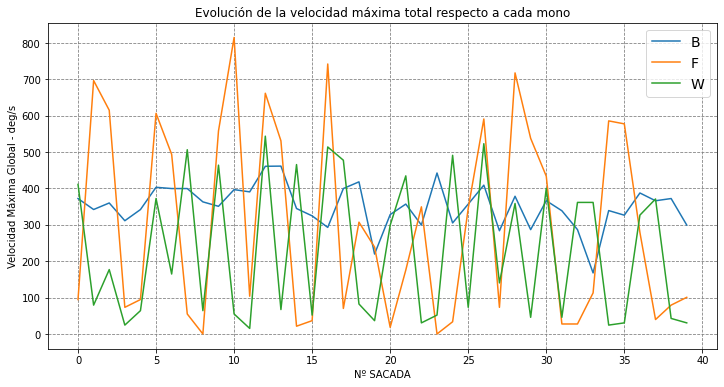

In [24]:
# PINTAMOS GRAFICAS DE EVOLUCION -> para ver si tiene relacion la evolucion de vmax con el mono
x = range(0,40)

#VMAX TOTAL
plt.figure(figsize=(12,6))
plt.plot(x,VMAX_B[:40],x,VMAX_F[:40],x,VMAX_W[:40])
plt.legend(('B','F','W'),
            prop = {'size': 14}, loc='upper right')
plt.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
plt.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
plt.xlabel('Nº SACADA')
plt.ylabel('Velocidad Máxima Global - deg/s')
plt.title('Evolución de la velocidad máxima total respecto a cada mono')

In [25]:
x = pd.DataFrame()
x['B']=VMAX_B
x['F']=VMAX_F
x['W']=VMAX_W
x.describe()

,B,F,W
count,290.000000,290.000000,290.000000
mean,344.139452,291.112463,198.126334
std,73.838762,251.389764,166.204621
min,94.653701,0.000000,0.000000
25%,299.504018,61.035156,36.621094
50%,347.907083,193.144197,137.329102
75%,391.021166,519.840257,347.300013
max,521.850586,878.911548,543.761244


## Bucle principal de transformación


In [ ]:
############ LECTURA DE DATOS ###################
ruta_ds = '2010_Adapt/'

##  DEFINIMOS LOS DATASETS
DF = pd.DataFrame(columns=['HE', 'VXmax', 'VX', 'a1x', 'a2x', 'AX', 'VE', 'VYmax', 
                           'VY', 'a1y', 'a2y', 'AY', 'HF','VF','T'])

num_files = len([f for f in os.listdir(ruta_ds)if os.path.isfile(os.path.join(ruta_ds, f))])
z = 0 #Contador del numero de archivos
i = 0 #Contador numero de ejemplos
flag=0
#Lectura y procesado de todos los ficheros adapt y creación de dataframe -> tarda como 10 minutos ejecutarse
for f in listdir(ruta_ds):
    #QUITAR DESPUES DE HACER LAS PRUEBAS
#     if z==2:
#         break
    #Contador de número de fichero    
    z += 1
    if(f.endswith('Adapt.smr') or f.endswith('List.smr')):
            print("Extrayendo datos de " + f +" (ARCHIVO " + str(z) +" de " + str(num_files) + ")...")
            #Creamos objeto reader Neo
            reader = neo.io.Spike2IO(filename=ruta_ds + f)
            #Leemos el bloque
            data = reader.read()[0]
            #Llamamos a las funciones para extraer la información
            eyex, tarx, t = dev_h(data)
            eyey, tary, t = dev_v(data)
            if(eyex[0] != 'x' and eyey[0] != 'x'):  
                inicio, final = cuando(data) #Instantes en los que empiezan-terminan las sacadas
                n = len(inicio) #Numero de sacadas en el fichero
                #Por cada mov sacadico
                for j in range(0,n):
                    pos_i, pos_f, i, f, dur = extrae(data, j)
                    s_eyex = eyex[pos_i:pos_f] #Posiciones del ojo durante la sacada
                    s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
                    vx = derivar(s_eyex, s_t) #Calculamos curva de velocidad
                    ax = derivar(vx, s_t) #Aceleracion horizontal
                    ax2 = gaussian_filter1d(ax, 3) #Suavizada
                    s_eyey = eyey[pos_i:pos_f] #Posiciones del ojo durante la sacada
                    s_t = t[pos_i:pos_f] #Instantes de tiempo durante la sacada
                    vy = derivar(s_eyey, s_t) #Calculamos curva de velocidad
                    ay = derivar(vy, s_t) #Aceleracion horizontal
                    ay2 = gaussian_filter1d(ay, 3) #Suavizada

                    #Horizontal
                    ei = eyex[pos_i]    #Pos inicial del ojo
                    ef = eyex[pos_f]    #Pos final del ojo
                    ct = s_t-min(s_t)   #Current time
                    vxmax = max(vx)
                    if(vxmax <= 0):
                        vxmax = min(vx)
                    axmax = max(ax2)
                    maxpos = np.where(ax2 == axmax)
                    axmin = min(ax2)
                    minpos = np.where(ax2 == axmin)
                    if(minpos[0][0]<maxpos[0][0]):
                        a1x=axmin
                        a2x=axmax
                    else:
                        a1x=axmax
                        a2x=axmin
                    #Vertical
                    ei2 = eyey[pos_i]    #Pos inicial del ojo
                    ef2 = eyey[pos_f]    #Pos final del ojo
                    vymax = max(vy)
                    if(vymax <= 0):
                        vymax = min(vy)
                    aymax = max(ay2)
                    maxpos = np.where(ay2 == aymax)
                    aymin = min(ay2)
                    minpos = np.where(ay2 == aymin)
                    if(minpos[0][0]<maxpos[0][0]):
                        a1y=aymin
                        a2y=aymax
                    else:
                        a1y=aymax
                        a2y=aymin
                    #Agregamos a diccionario

                    if(len(vx) > 30 and len(vy) > 30):
                        d={'HE': ei, 'VXmax': vxmax, 'VX': vx, 'a1x':a1x, 'a2x':a2x, 'AX':ax2, 
                           'VE': ei2, 'VYmax': vymax, 'VY':vy, 'a1y':a1y, 'a2y':a2y, 'AY':ay2,
                           'HF':ef, 'VF':ef2,'T':ct}
                        DF.loc[i] = d
                        i += 1
        
DF = DF.reset_index(drop=True)

In [ ]:
#Guardar o cargar  dataset almacenado
DF.to_csv('DATAFRAME.csv', index=False)
#DF = pd.read_csv('DATAFRAME.csv')